In [1]:
from utils.files import mkExpDir
from dataset import dataloader
from model import ETMAG
from loss.loss import get_loss_dict
from trainer import Trainer

import os
import torch
import torch.nn as nn
import warnings
import glob
import time

from argparse import Namespace
from torchinfo import summary
from utils.ploting import plot_results

warnings.filterwarnings('ignore')


import math
import numpy as np
import logging
import cv2
import os
import shutil

import torch
import seaborn as sns
import matplotlib.pyplot as plt

/opt/miniconda3/envs/torch_latest/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/miniconda3/envs/torch_latest/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


# Args

In [2]:
from argparse import Namespace

In [3]:
args   = Namespace()

In [4]:
## log setting
args.save_dir      = 'ignore'
args.reset         =  True
args.log_file_name = 'ETMAG.log'
args.logger_name   = 'ETMAG'
## device setting
args.cpu           = False
args.num_gpu       = 1
## dataset setting
args.dataset       = 'urban100'                      # Which dataset to train and test
args.dataset_dir   = r'/home/esteban/Data/Sun80/' # Directory of dataset
args.num_workers   = 1                            # The number of workers when loading data

In [5]:
args.num_res_blocks  = '8+16+8+4' # Residula blocks for features [lv1, lv2, lv3, merge_feats]
args.num_grad_blocks = '8+9+9+9'   # # Residual blocks for features [IFE, lv1, lv2, lv3]

args.n_feats        = 64          # The number of channels in network
args.res_scale      = 1.0         # Residual scale
args.top_k          = 2           # Top K matches for each patch
args.GAN_k          = 2           # Training discriminator k times when training generator once

args.rec_w          = 1.0         # The weight of reconstruction loss
args.per_w          = 1e-2        # The weight of perceptual loss
args.grd_w          = 1e-3          # The weight of transferal perceptual loss
args.adv_w          = 1e-3        # The weight of adversarial loss

## optimizer setting
args.beta1          = 0.9         # The beta1 in Adam optimizer
args.beta2          = 0.999       # The beta2 in Adam optimizer
args.eps            = 1e-8        # The eps in Adam optimizer
args.lr_rate        = 1e-4        # Learning rate
args.lr_rate_dis    = 1e-4        # Learning rate of discriminator
args.lr_rate_lte    = 1e-5        # Learning rate of LTE
args.decay          = 1e-4      # Learning rate decay type
args.gamma          = 0.5         # Learning rate decay factor for step decay

## Patch Setting and Top Features Setting
args.unfold_kernel_size = 6
args.stride             = 2
args.padding            = 2

In [6]:
args.batch_size        = 9    # Training batch size
args.img_training_size = 160  # Training data crop size
args.num_init_epochs   = 2    # The number of init epochs which are trained with only reconstruction loss
args.num_epochs        = 300  # The number of training epochs
args.print_every       = 600  # Print period
args.save_every        = 5    # Save period
args.val_every         = 1    # Validation period
args.show_every        = 5    # Plot Results


## evaluate / test / finetune setting
args.eval              = True                      # Evaluation mode
args.eval_save_results = False                     # Save each image during evaluation
args.model_path        = None                      # The path of model to evaluation
args.test              = False                     # Test mode

# Main



In [7]:
# make save_dir
_logger     = mkExpDir(args)

In [8]:
# dataloader of training set and testing set
_dataloader = dataloader.get_dataloader(args) if (not args.test) else None

In [9]:
len(_dataloader['test'])

80

In [10]:
# device and model
device = torch.device('cuda') # Choose CPU or GPU
torch.cuda.set_device(0)      # Select GPI ID

In [11]:
_model    = ETMAG.ETMAG(args).to(device)

if ((not args.cpu) and (args.num_gpu > 1)):
  _model  = nn.DataParallel(_model, list(range(args.num_gpu)))

_loss_all = get_loss_dict(args, _logger)
t         = Trainer(args, _logger, _dataloader, _model, _loss_all)

In [12]:
t.load('./save_dir_gan/model/model_00215.pt')

[trainer.py file line:53] - INFO: load_model_path: ./save_dir_gan/model/model_00215.pt


In [13]:
t.evaluate(current_epoch = -1)

[trainer.py file line:126] - INFO: Epoch -1 evaluation process...
[trainer.py file line:192] - INFO: Ref  PSNR (now): 29.024 	 SSIM (now): 0.7886
[trainer.py file line:199] - INFO: Ref  PSNR (max): 29.024 (-1) 	 SSIM (max): 0.7886 (-1)
[trainer.py file line:202] - INFO: Evaluation over.


In [14]:
def prepare(sample_batched, device):
    for key in sample_batched.keys():
        sample_batched[key] = sample_batched[key].to(device)
    return sample_batched

def plot_results(model = None, dataloader = None, total_images = 5, save = False, epoch = 0, device = None, args = None) :
    i = 0
    for sample_batched in dataloader['test']:
        sample_batched = prepare(sample_batched, device)
        lr             = sample_batched['LR']
        lr_sr          = sample_batched['LR_sr']
        hr             = sample_batched['HR']
        ref            = sample_batched['Ref']
        ref_sr         = sample_batched['Ref_sr']
        
        print(lr.shape, lr_sr.shape, hr.shape)

        model.eval()
        with torch.no_grad():
            sr, S, _, _, _ = model(lr = lr, lrsr = lr_sr, ref = ref, refsr = ref_sr)
            sr_save = (sr+1.) * 127.5
            
            lr     = (lr     + 1) * 127.5
            lr_sr  = (lr_sr  + 1) * 127.5
            hr     = (hr     + 1) * 127.5
            ref    = (ref    + 1) * 127.5
            ref_sr = (ref_sr + 1) * 127.5
            
            sr_save_ = np.transpose(sr_save[0].squeeze().round().cpu().numpy(), (1, 2, 0)).astype(np.uint8)
            lr_      = np.transpose(lr[0].squeeze().round().cpu().numpy(), (1, 2, 0)).astype(np.uint8)
            lr_sr_   = np.transpose(lr_sr[0].squeeze().round().cpu().numpy(), (1, 2, 0)).astype(np.uint8)
            hr_      = np.transpose(hr[0].squeeze().round().cpu().numpy(), (1, 2, 0)).astype(np.uint8)
            ref_     = np.transpose(ref[0].squeeze().round().cpu().numpy(), (1, 2, 0)).astype(np.uint8)
            ref_sr_  = np.transpose(ref_sr[0].squeeze().round().cpu().numpy(), (1, 2, 0)).astype(np.uint8)

            # plot
            names       = ['LR', 'LR_sr', 'TTSR', 'Ref', 'Ref_sr', 'Target']
            num_classes = len(names)

            fig, ax = plt.subplots(figsize = (50,20), nrows = 1, ncols = 6, sharex = True, sharey = True,)
            ax      = ax.flatten()

            ax[0].imshow(lr_)
            ax[0].set_xlabel(str(0) + ': '+ names[0])

            ax[1].imshow(lr_sr_)
            ax[1].set_xlabel(str(1) + ': '+ names[1])

            ax[2].imshow(sr_save_)
            ax[2].set_xlabel(str(2) + ': '+ names[2])
            
            ax[3].imshow(ref_)
            ax[3].set_xlabel(str(3) + ': '+ names[3])
            
            ax[4].imshow(ref_sr_)
            ax[4].set_xlabel(str(4) + ': '+ names[4])
            
            ax[5].imshow(hr_)
            ax[5].set_xlabel(str(5) + ': '+ names[5])


            ax[0].set_xticks([])
            ax[0].set_yticks([])
            plt.show()

            if save :
                # Save the full figure...
                fig.savefig(args.save_dir + '/model_' + str(epoch) + '_' + str(i) + '.png')
                
            map_ = sns.heatmap(S[0].detach().cpu().numpy()[0][0], linewidth=0)
            print(S[0].detach().cpu().numpy()[0][0].max(), S[0].detach().cpu().numpy()[0][0].min())
            plt.show()
            if save :
                figure = map_.get_figure()    
                figure.savefig(args.save_dir + '/heatmap_' + str(epoch) + '_' + str(i) + '.png')
        
        if i == total_images - 1 : 
            return
        i += 1

torch.Size([1, 3, 200, 256]) torch.Size([1, 3, 800, 1024]) torch.Size([1, 3, 800, 1024])


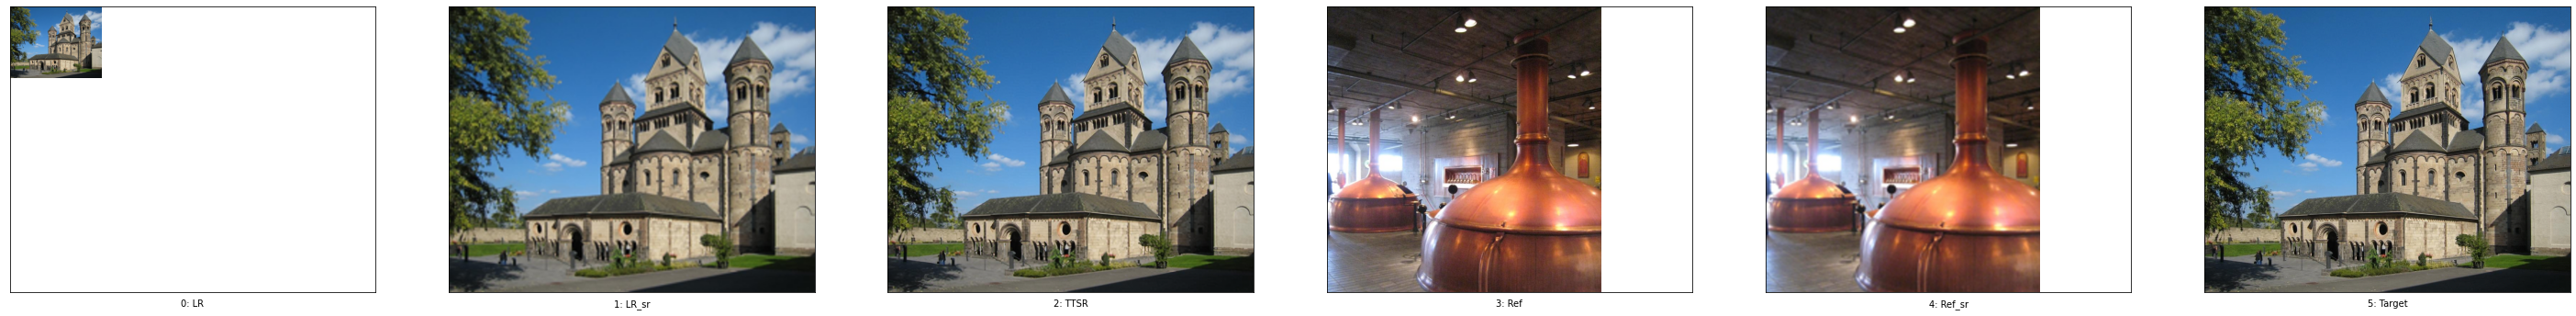

0.29451877 0.10686318


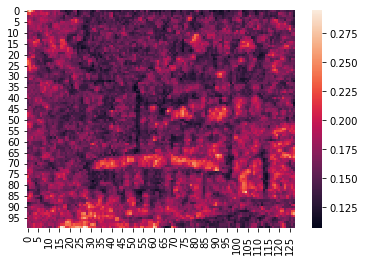

torch.Size([1, 3, 192, 256]) torch.Size([1, 3, 768, 1024]) torch.Size([1, 3, 768, 1024])


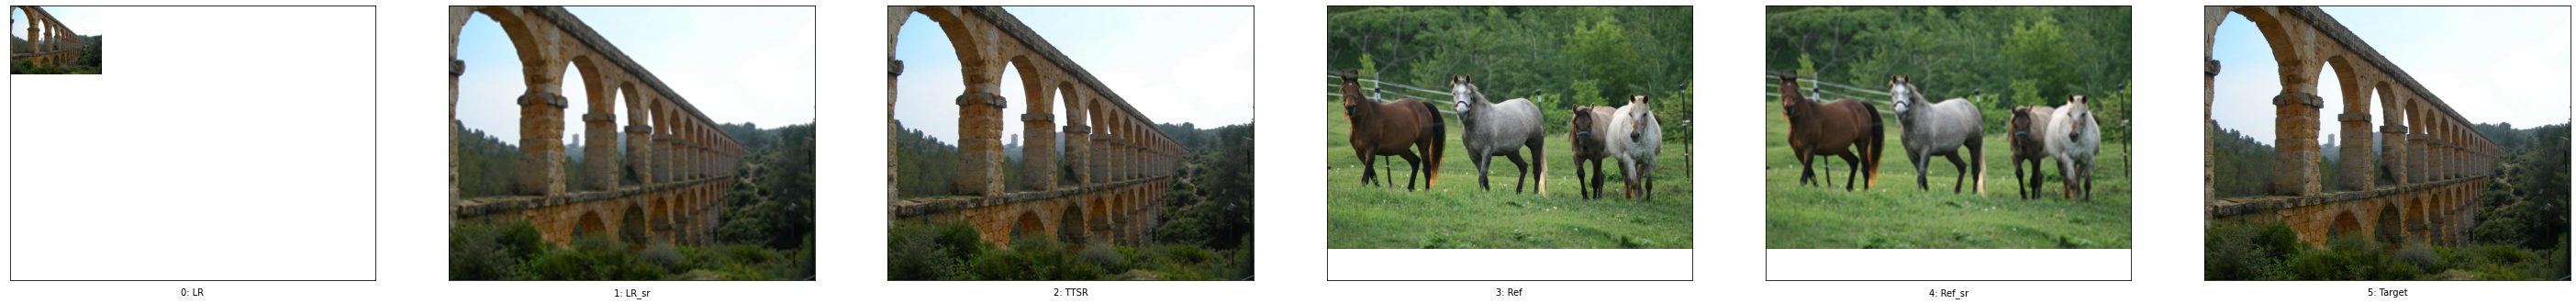

0.3536674 0.09143633


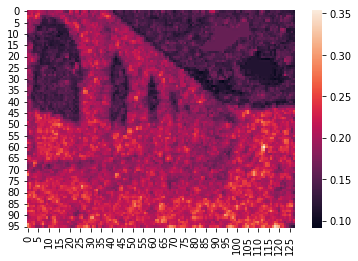

torch.Size([1, 3, 170, 256]) torch.Size([1, 3, 680, 1024]) torch.Size([1, 3, 680, 1024])


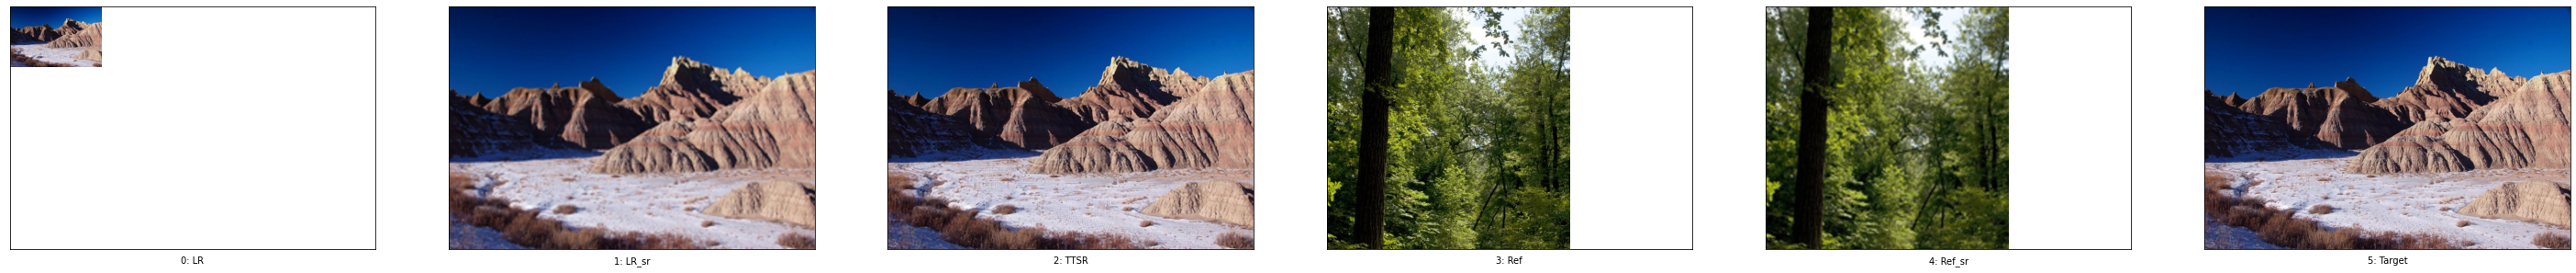

0.2502677 0.07280491


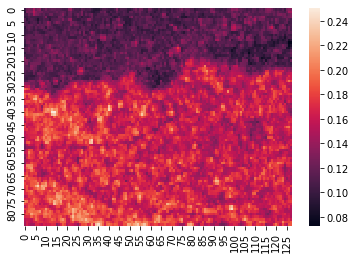

torch.Size([1, 3, 170, 256]) torch.Size([1, 3, 680, 1024]) torch.Size([1, 3, 680, 1024])


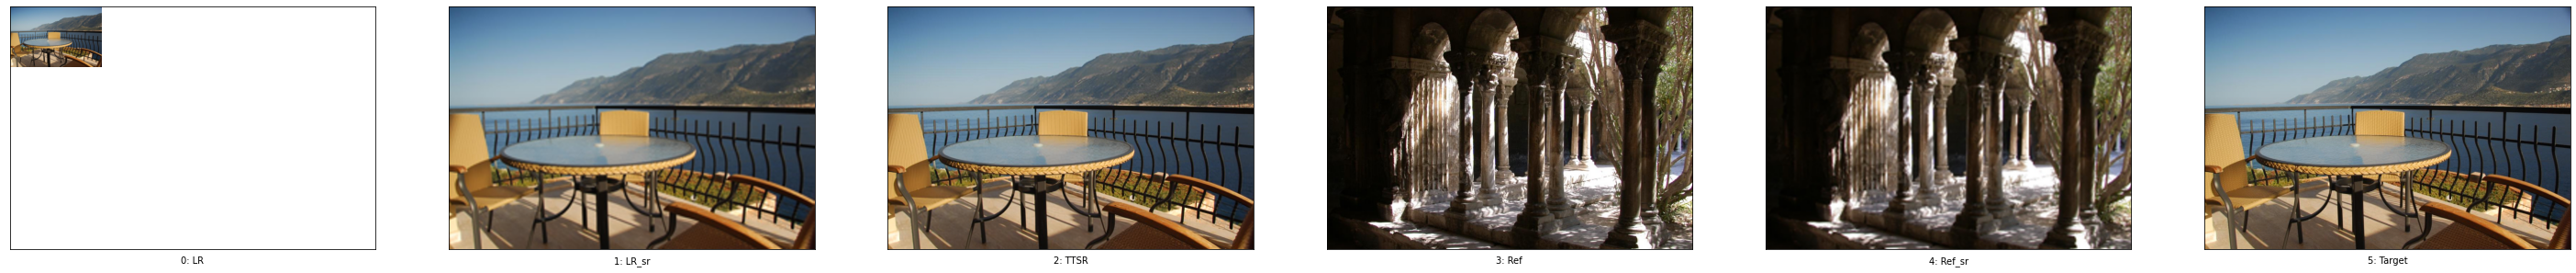

0.2755404 0.08008685


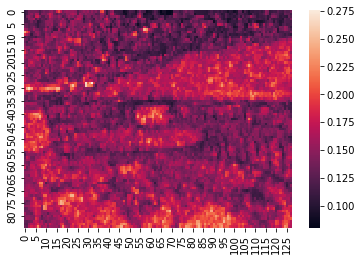

torch.Size([1, 3, 192, 256]) torch.Size([1, 3, 768, 1024]) torch.Size([1, 3, 768, 1024])


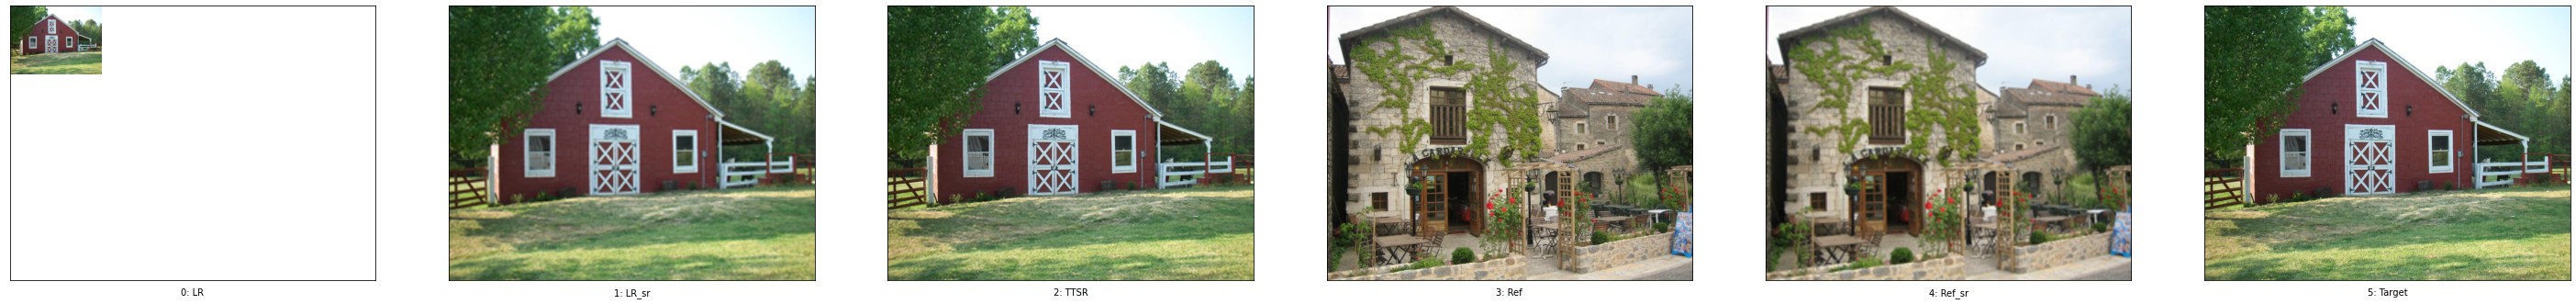

0.99999976 0.09916014


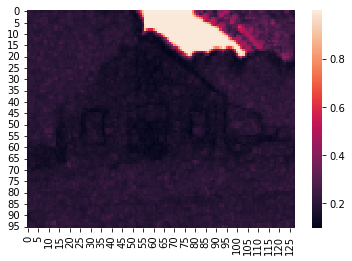

In [15]:
plot_results(model = t.model, dataloader = _dataloader, total_images = 5, save = False, epoch = -1, device = device)